<a href="https://colab.research.google.com/github/KelvinLam05/Cohort-Retention-Analysis/blob/main/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

The aim of this project will be to perform a cohort analysis.

**Data set information**

Detailed data on sales of consumer goods obtained by ‘scanning’ the bar codes for individual products at electronic points of sale in a retail store. The data provide detailed information about quantities, characteristics and values of goods sold as well as their prices.

The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year.

**Attribute information**

* Date of Sales Transaction

* Customer ID

* Transaction ID

* SKU Category ID

* SKU ID

* Quantity Sold

* Sales Amount

In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [ ]:
# Load the data
df = pd.read_csv('/content/scanner_data.csv', parse_dates = ['Date'])

In [ ]:
# Examine the data
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88


In [ ]:
# Change column names to lower case
df.columns = map(str.lower, df.columns)

In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unnamed: 0      131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  float64       
 7   sales_amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 8.0+ MB


In [ ]:
# Convert the quantity column to an int
df['quantity'] = df['quantity'].apply(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unnamed: 0      131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  int64         
 7   sales_amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 8.0+ MB


In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

sales_amount      0
quantity          0
sku               0
sku_category      0
transaction_id    0
customer_id       0
date              0
unnamed: 0        0
dtype: int64

In [ ]:
# We keep only the relevant columns and drop duplicated values 
df = df[['customer_id', 'transaction_id', 'date']].drop_duplicates()

We want to split up our customers in groups based on the month that they became customer.

In [ ]:
# Group by customer_id and select only the date column
## Take the earliest date of each customer and assign it back to the orignal dataset
df['cohort_month'] = df.groupby('customer_id')['date'] \
                       .transform('min') \
                       .dt.to_period('M') 

In [ ]:
df.head()

,customer_id,transaction_id,date,cohort_month
0,2547,1,2016-02-01,2016-01
1,822,2,2016-02-01,2016-01
2,3686,3,2016-02-01,2016-01
3,3719,4,2016-02-01,2016-01
4,9200,5,2016-02-01,2016-02


In [ ]:
# We find the truncated month of the purchase date
df['order_month'] = df['date'].dt.to_period('M')

In [ ]:
df.head()

,customer_id,transaction_id,date,cohort_month,order_month
0,2547,1,2016-02-01,2016-01,2016-02
1,822,2,2016-02-01,2016-01,2016-02
2,3686,3,2016-02-01,2016-01,2016-02
3,3719,4,2016-02-01,2016-01,2016-02
4,9200,5,2016-02-01,2016-02,2016-02


Then, we aggregate the data per cohort_month and order_month and count the number of unique customers in each group. Additionally, we add the period_number, which indicates the number of periods between the cohort month and the month of the purchase.

In [ ]:
df_cohort = df.groupby(['cohort_month', 'order_month']) \
              .agg(n_customers = ('customer_id', 'nunique')) \
              .reset_index(drop = False)

In [ ]:
df_cohort.head()

,cohort_month,order_month,n_customers
0,2016-01,2016-01,3817
1,2016-01,2016-02,1104
2,2016-01,2016-03,971
3,2016-01,2016-04,899
4,2016-01,2016-05,823


In [ ]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort_month).apply(attrgetter('n'))

In [ ]:
df_cohort.head()

,cohort_month,order_month,n_customers,period_number
0,2016-01,2016-01,3817,0
1,2016-01,2016-02,1104,1
2,2016-01,2016-03,971,2
3,2016-01,2016-04,899,3
4,2016-01,2016-05,823,4


The next step is to pivot the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.

In [ ]:
# Create a pivot
cohort_pivot = df_cohort.pivot_table(index = 'cohort_month', columns = 'period_number', values = 'n_customers')

In [ ]:
cohort_pivot.head()

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2016-01,3817.0,1104.0,971.0,899.0,823.0,697.0,718.0,723.0,701.0,635.0,697.0,716.0
2016-02,2759.0,550.0,515.0,511.0,436.0,420.0,444.0,457.0,448.0,463.0,435.0,NaN
2016-03,2619.0,568.0,532.0,479.0,476.0,456.0,469.0,466.0,459.0,505.0,NaN,NaN
2016-04,2292.0,436.0,399.0,366.0,368.0,416.0,363.0,391.0,389.0,NaN,NaN,NaN
2016-05,2180.0,315.0,314.0,292.0,321.0,336.0,310.0,325.0,NaN,NaN,NaN,NaN


To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.

Retention rate = # customers current period / # customers starting period


In [ ]:
# Select the first column and store it to cohort_sizes
cohort_size = cohort_pivot.iloc[:,0]

In [ ]:
# Divide the cohort count by cohort sizes along the rows
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [ ]:
retention_matrix.head()

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2016-01,1.0,0.289232,0.254388,0.235525,0.215614,0.182604,0.188106,0.189416,0.183652,0.166361,0.182604,0.187582
2016-02,1.0,0.199348,0.186662,0.185212,0.158028,0.152229,0.160928,0.165640,0.162378,0.167814,0.157666,NaN
2016-03,1.0,0.216877,0.203131,0.182894,0.181749,0.174112,0.179076,0.177931,0.175258,0.192822,NaN,NaN
2016-04,1.0,0.190227,0.174084,0.159686,0.160558,0.181501,0.158377,0.170593,0.169721,NaN,NaN,NaN
2016-05,1.0,0.144495,0.144037,0.133945,0.147248,0.154128,0.142202,0.149083,NaN,NaN,NaN,NaN


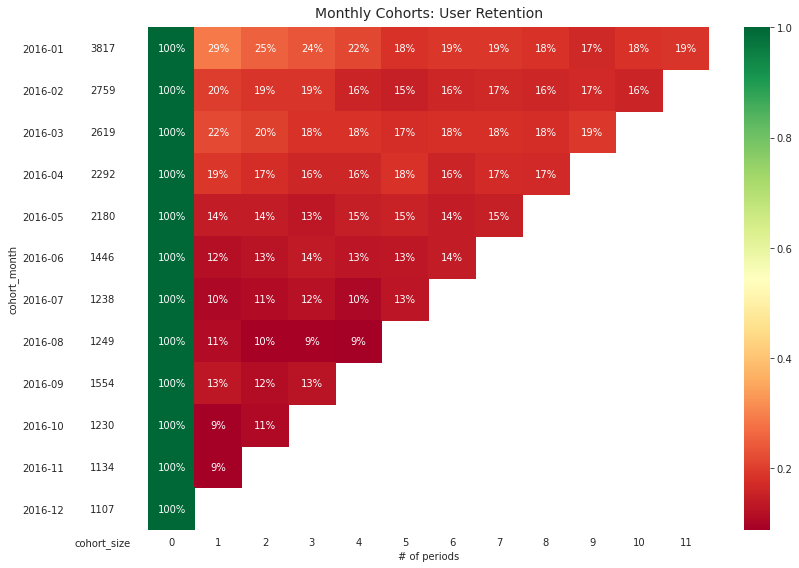

In [ ]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey = True, gridspec_kw = {'width_ratios': [1, 11]})
    
    # Retention matrix
    sns.heatmap(retention_matrix, 
                mask = retention_matrix.isnull(), 
                annot = True, 
                fmt = '.0%', 
                cmap = 'RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize = 14, pad = 10)
    ax[1].set(xlabel = '# of periods',
              ylabel = '')

    # Cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns = {0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot = True, 
                cbar = False, 
                fmt = 'g', 
                cmap = white_cmap, 
                ax = ax[0])

    fig.tight_layout()

* In the image, we can see that there is a sharp drop-off in the second month (indexed as 1) already, on average around 85% of customers do not make any purchase in the second month. 

* Customers acquired later on are churning faster. Of the people that became our customer in November, only 9% of the customers made a purchase 1 months after their initial purchase.

* Overall, the retention matrix showed a slow downward trend in the retention rate after the initial plunge.